In [4]:
%matplotlib notebook

import gillespy2
from gillespy2.solvers.numpy import NumPySSASolver
from tsfresh.feature_extraction.settings import MinimalFCParameters
import numpy as np
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.priors import uniform_prior

from dask.distributed import Client

## Define Model

In [5]:
class ToggleSwitch(gillespy2.Model):
    """ Gardner et al. Nature (1999)
    'Construction of a genetic toggle switch in Escherichia coli'
    """
    def __init__(self, parameter_values=None):
        # Initialize the model.
        gillespy2.Model.__init__(self, name="toggle_switch")
        # Parameters
        alpha1 = gillespy2.Parameter(name='alpha1', expression=1)
        alpha2 = gillespy2.Parameter(name='alpha2', expression=1)
        beta = gillespy2.Parameter(name='beta', expression="2.0")
        gamma = gillespy2.Parameter(name='gamma', expression="2.0")
        mu = gillespy2.Parameter(name='mu', expression=1.0)
        self.add_parameter([alpha1, alpha2, beta, gamma, mu])

        # Species
        U = gillespy2.Species(name='U', initial_value=10)
        V = gillespy2.Species(name='V', initial_value=10)
        self.add_species([U, V])

        # Reactions
        cu = gillespy2.Reaction(name="r1",reactants={}, products={U:1},
                propensity_function="alpha1/(1+pow(V,beta))")
        cv = gillespy2.Reaction(name="r2",reactants={}, products={V:1},
                propensity_function="alpha2/(1+pow(U,gamma))")
        du = gillespy2.Reaction(name="r3",reactants={U:1}, products={},
                rate=mu)
        dv = gillespy2.Reaction(name="r4",reactants={V:1}, products={},
                rate=mu)
        self.add_reaction([cu,cv,du,dv])
        self.timespan(np.linspace(0,50,101))

toggle_model = ToggleSwitch()

## Define simulator function

In [6]:
def set_model_parameters(params, model):
    """ params - array, needs to have the same order as
        model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model


def simulator(params, model):

    model_update = set_model_parameters(params, model)
    num_trajectories = 1  # TODO: howto handle ensembles

    res = model_update.run(solver=NumPySSASolver, show_labels=False,
                           number_of_trajectories=num_trajectories)
    tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)  
    tot_res = tot_res[:,1:, :] # should not contain timepoints
    
    return tot_res


def simulator2(x):
    return simulator(x, model=toggle_model)

## Define parameter sampler and summary stats

In [7]:
# Set up the prior
default_param = np.array(list(toggle_model.listOfParameters.items()))[:,1]
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    
true_params = np.array(bound)
dmin = true_params * 0.5
dmax = true_params * 2.0

uni_prior = uniform_prior.UniformPrior(dmin, dmax)

default_fc_params = {'mean': None,
                         'variance': None,
                         'skewness': None,
                         'agg_autocorrelation':
                         [{'f_agg': 'mean', 'maxlag': 5},
                          {'f_agg': 'median', 'maxlag': 5},
                          {'f_agg': 'var', 'maxlag': 5}]}

summaries = auto_tsfresh.SummariesTSFRESH(features=default_fc_params, corrcoef=True)

## Start local cluster using dask client

In [14]:
c = Client('192.168.1.6:8786')
c

Client Scheduler: tcp://192.168.1.6:8786 Dashboard: http://192.168.1.6:8787/status,Cluster Workers: 31 Cores: 62 Memory: 128.23 GB


## Initiate StochMET

In [9]:
from sciope.stochmet.stochmet import StochMET


#will use default minimal set of features
met = StochMET(sim=simulator2, sampler=uni_prior, summarystats=summaries)

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Run parameter sweep (will persist and running in background)

In [16]:
met.compute(n_points=1000, chunk_size=10)

## Explore the result
Here we will explore parameter points expressed in feature space using a dimension reduction method. User can interact with points and label points according to different model behavior

In [17]:
#First lets add some appropiate information about the model and features
met.data.configurations['listOfParameters'] = list(toggle_model.listOfParameters.keys())
met.data.configurations['listOfSpecies'] = list(toggle_model.listOfSpecies.keys())
met.data.configurations['listOfSummaries'] = met.summaries.features
met.data.configurations['timepoints'] = toggle_model.tspan

<IPython.core.display.Javascript object>


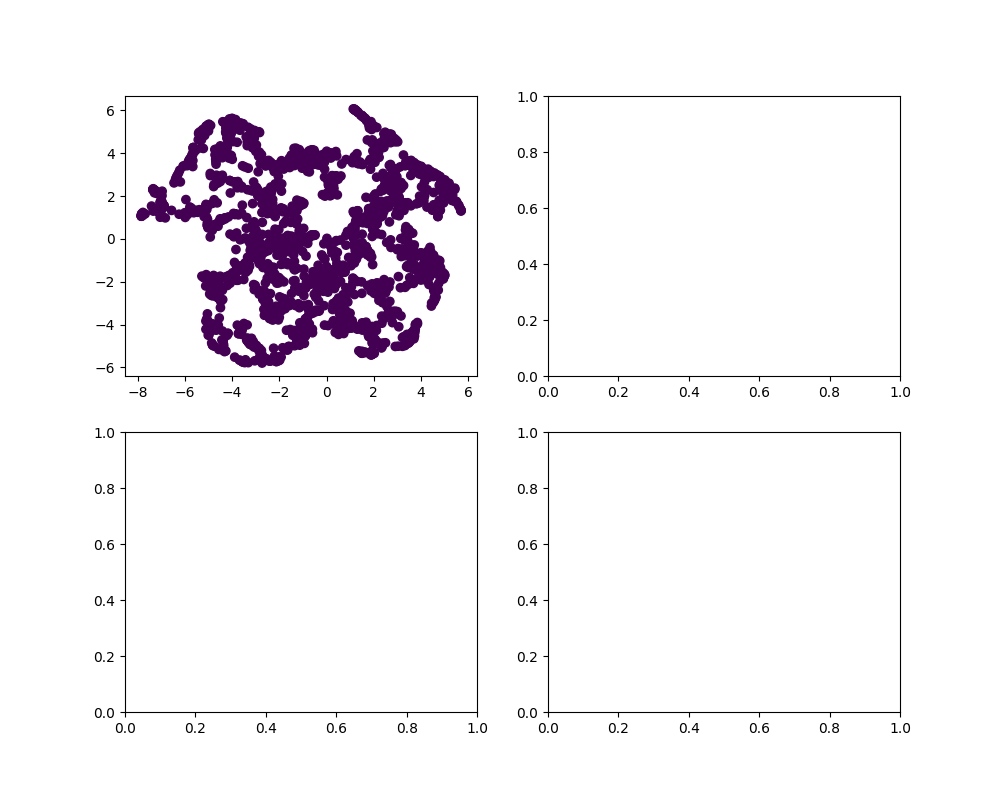

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'U': 0, 'V': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'U': 0, 'V': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,0.739224,1.380436,3.547197,1.716283,1.886580
1,1.806645,0.960227,2.621243,3.970334,1.884694
2,0.828815,0.740194,3.247536,2.249434,1.462993
3,0.548426,1.085376,3.206300,2.497645,0.595751
4,0.591425,0.628459,1.696998,2.910434,1.774072
...,...,...,...,...,...
1865,1.596919,0.609541,1.198964,2.098459,1.055620
1866,0.639269,1.175049,1.332315,2.494136,0.635921
1867,0.573470,0.708293,2.149588,1.822608,1.709039
1868,1.516143,0.840860,1.025333,3.892355,1.645910


In [18]:
# Here we use UMAP for dimension reduction and collect the data from persited storage
met.explore(dr_method='umap')

## Once a few points has been added we can use Semi-supervised learning

In [78]:
from sciope.models.label_propagation import LPModel
#here lets use the dimension reduction embedding as input data
data = met.dr_model.embedding_

model_lp = LPModel()
#train using basinhopping
model_lp.train(data, met.data.user_labels, min_=0.01, max_=10, niter=50)

basinhopping step 0: f 0.564619
basinhopping step 1: f 0.301309 trial_f 0.301309 accepted 1  lowest_f 0.301309
found new global minimum on step 1 with function value 0.301309
basinhopping step 2: f 0.301492 trial_f 0.301492 accepted 1  lowest_f 0.301309
basinhopping step 3: f 0.301309 trial_f 0.301309 accepted 1  lowest_f 0.301309
basinhopping step 4: f 0.301325 trial_f 0.301325 accepted 1  lowest_f 0.301309
basinhopping step 5: f 0.301321 trial_f 0.301321 accepted 1  lowest_f 0.301309
basinhopping step 6: f 0.301414 trial_f 0.301414 accepted 1  lowest_f 0.301309
basinhopping step 7: f 0.30132 trial_f 0.30132 accepted 1  lowest_f 0.301309
basinhopping step 8: f 0.301979 trial_f 0.301979 accepted 1  lowest_f 0.301309
basinhopping step 9: f 0.301309 trial_f 0.301309 accepted 1  lowest_f 0.301309
basinhopping step 10: f 0.302988 trial_f 0.302988 accepted 1  lowest_f 0.301309
basinhopping step 11: f 0.301309 trial_f 0.301309 accepted 1  lowest_f 0.301309
basinhopping step 12: f 0.301309 tr

In [82]:
# just to vislualize the result we will map the label distribution to the user_labels (will enable us to see the LP model 
# output when using "explore")

user_labels = np.copy(met.data.user_labels)
met.data.user_labels = model_lp.model.label_distributions_[:,1]

In [ ]:
met.dr_model.

<IPython.core.display.Javascript object>


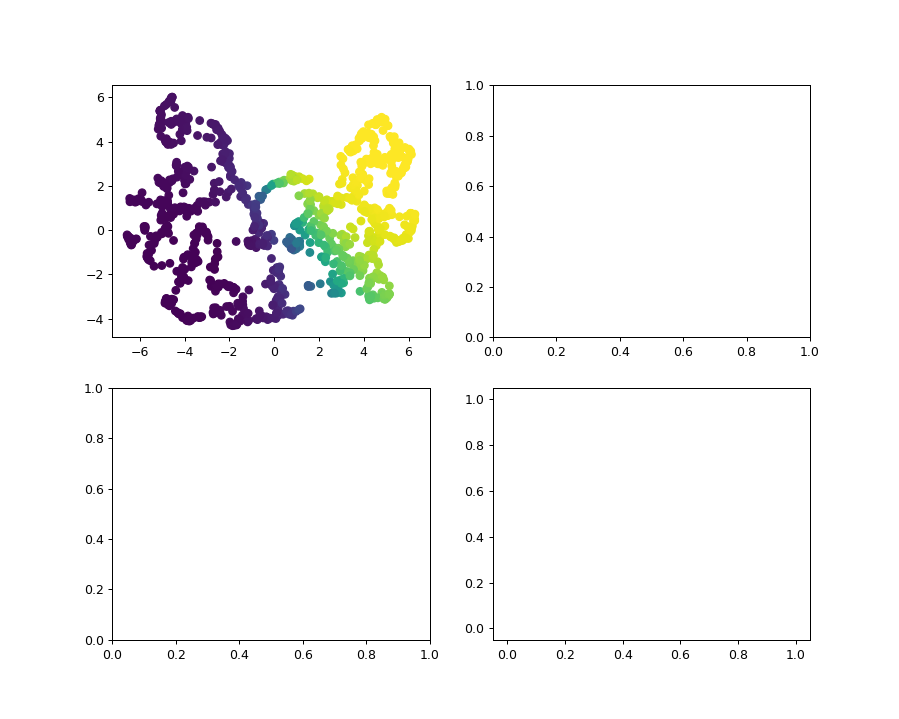

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'U': 0, 'V': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'U': 0, 'V': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,1.255858,1.786885,1.635029,2.632046,1.804870
1,1.704634,1.777602,3.972119,2.915392,1.407230
2,1.378560,1.535923,3.842468,1.932253,0.733642
3,0.808019,0.780946,3.325485,2.267524,0.845967
4,1.509194,0.605753,2.009808,1.277992,1.666000
5,1.265026,1.762228,3.576408,1.990164,0.545608
6,1.799744,1.024645,2.403373,3.738790,1.827588
7,1.484175,0.917945,2.329194,3.858224,1.028777
8,0.560280,1.316849,1.167354,2.018834,1.322887
9,1.695352,1.283965,1.186530,2.389604,0.716301


In [83]:
met.explore(dr_method='umap')

In [ ]:
met.data.user_labels = user_labels